
# Intro to Pytorch

Let's explore the XOR problem. First of all go ahead and do the follwing:

- Define your data.
- Define your bround truths.
- convert all of the above to tensor and convert to float.

In [12]:
import numpy as np
import torch

X = np.array([[0, 0], [0, 1], [1,0], [1, 1]])

gates = {'OR': np.array([0,1,1,1]),
         'AND': np.array([0,0,0,1]),
         'XOR': np.array([0,1,1,0])}


Xt = torch.from_numpy(X).float()
y = torch.from_numpy(gates['XOR']).float()

In [13]:
Xt.shape

torch.Size([4, 2])

In [15]:
y.shape

torch.Size([4])


Pytorch has a pretty lucid object oriented interface, and I've provided the core of th class definiton you need below. Let's go ahead and plug in some dense layers gusing the `nn.Linear` module in the last session. For this round let's fall back on the configuration that uses the following:

- A one dimensional output.
- A single Rectified Linear Unit.
- Two hidden neurons should be enough but feel free to experiment here.
- Feel free to call the class whatever you'd like!


In [4]:
from IPython.display import IFrame
IFrame(src='https://drive.google.com/file/d/12r-yy2lYIpn4v0ULf8jFMDygPyKaNGSj/preview', width=500, height=300)

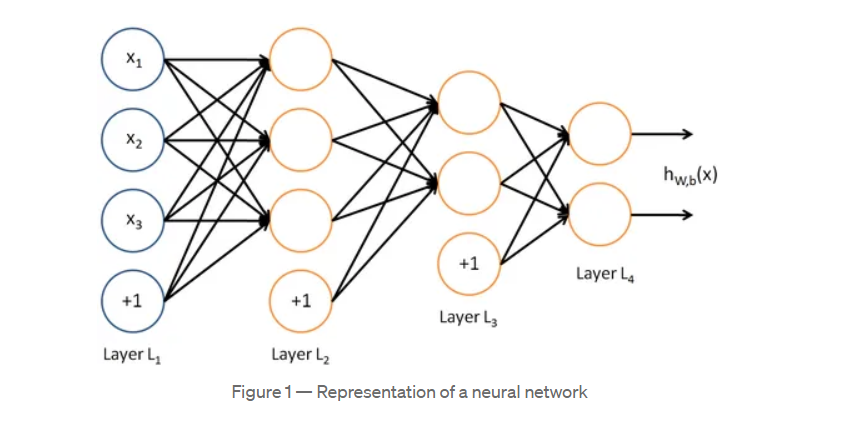


Based on nature, neural networks are the usual representation we make of the brain : neurons interconnected to other neurons which forms a network. A simple information transits in a lot of them before becoming an actual thing, like “move the hand to pick up this pencil”.

The operation of a complete neural network is straightforward : one enter variables as inputs (for example an image if the neural network is supposed to tell what is on an image), and after some calculations, an output is returned (following the first example, giving an image of a cat should return the word “cat”).

Now, you should know that artificial neural network are usually put on columns, so that a neuron of the column n can only be connected to neurons from columns n-1 and n+1. There are few types of networks that use a different architecture, but we will focus on the simplest for now.

Neural networks can usually be read from left to right. Here, the first layer is the layer in which inputs are entered. There are 2 internals layers (called hidden layers) that do some math, and one last layer that contains all the possible outputs. Don’t bother with the “+1”s at the bottom of every columns. It is something called “bias”

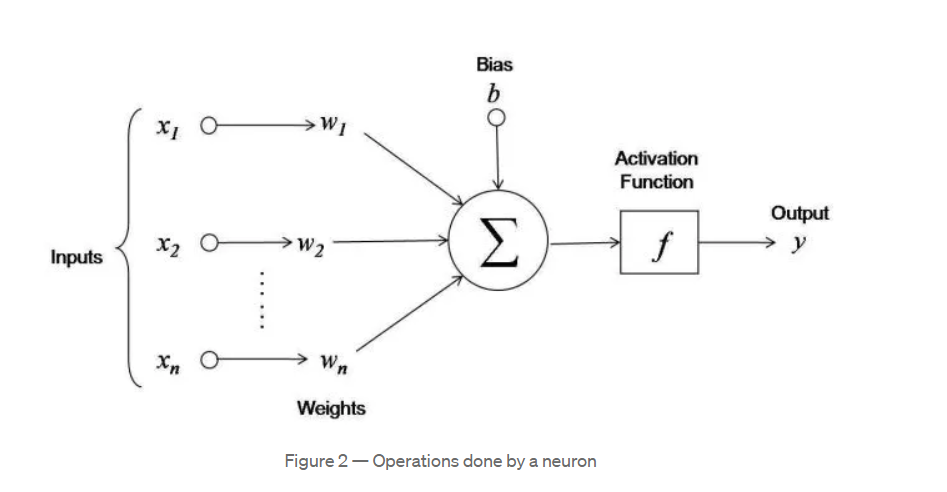

The operations done by each neurons are pretty simple :

First, it adds up the value of every neurons from the previous column it is connected to. On the Figure 2, there are 3 inputs (x1, x2, x3) coming to the neuron, so 3 neurons of the previous column are connected to our neuron.

This value is multiplied, before being added, by another variable called “weight” (w1, w2, w3) which determines the connection between the two neurons. Each connection of neurons has its own weight, and those are the only values that will be modified during the learning process.

Moreover, a bias value may be added to the total value calculated. It is not a value coming from a specific neuron and is chosen before the learning phase, but can be useful for the network.

After all those summations, the neuron finally applies a function called “activation function” to the obtained value.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, input_dim, num_classes):
        super(Net, self).__init__()
        self.fcin = nn.Linear(input_dim, 4)
        self.fcout = nn.Linear(4, num_classes)

    def forward(self, x):
        x = torch.relu(self.fcin(x))
        x = self.fcout(x)
        return x


Let's take a look at what's going on here:

- Notice on initialization the super constructir is called. This is simply because we're employing `nn.Linear` from `nn.Module` and that particular superclass need to be initalissed in order to become available within our custom class.

- The real flexibility of this methodology lies in the fact that we can define our layers as objects and later chop and change, add lonlinearities etc in the forward pass.

Before we discuss further however go ahead and:

- initialize your new network class given what you know about OOP.
- pass in our data.

**Hint**

- within the core code I gave you we require both `input_dim` and `num_classes`.

In [19]:
model = Net(2, 1)
outputs = model(Xt)
print(outputs)

tensor([[0.3143],
        [0.4514],
        [0.3442],
        [0.3307]], grad_fn=<AddmmBackward0>)


Given that let's go ahead and put together a simple loader with Pytorch's  DataLoader class. For now we'll shy away from any need for normalization or augmentation given the simplicity of the problem.

In [22]:
import torch.utils.data as data_utils

train = data_utils.TensorDataset(Xt, y)

train_loader = data_utils.DataLoader(train , batch_size=1 , shuffle=True)
train_loaderb4 = data_utils.DataLoader(train , batch_size=2 , shuffle=True)

In [23]:
print('batch: 1\n')

for batch_idx,(data , labels) in enumerate(train_loader):
  print(f'input {batch_idx}: {data}, target: {labels}')

print('\nbatch: 4\n')

for batch_idx,(data , labels) in enumerate(train_loaderb4):
  print(f'input {batch_idx}: {data}, target: {labels}')

batch: 1

input 0: tensor([[0., 0.]]), target: tensor([0.])
input 1: tensor([[0., 1.]]), target: tensor([1.])
input 2: tensor([[1., 1.]]), target: tensor([0.])
input 3: tensor([[1., 0.]]), target: tensor([1.])

batch: 4

input 0: tensor([[1., 1.],
        [1., 0.]]), target: tensor([0., 1.])
input 1: tensor([[0., 1.],
        [0., 0.]]), target: tensor([1., 0.])


Now looking at our data loaders here it's easy to see how we might be able to go about intercepting out training data and pushing it through a forward pass, where epochs represent a complete forward and backward pass through the entire datset.

Before we go ahead and begin to add loss and backpropogation into our training loop - Given the description above go ahead and use the data loader to feed what we have into ourn model.

**Note** Notice I've got you on your feet with the first of you nested loops here.

In [26]:
num_epochs = 10
print(train_loaderb4)
for i in range(num_epochs):
  for batch_idx,(data , labels) in enumerate(train_loaderb4):
    outputs = model(data)

print(outputs)

tensor([[0.3307],
        [0.4514]], grad_fn=<AddmmBackward0>)


Great! We're getting somewhere but we're not learning anything. You'll recall from your previous sessions that this is where all of the magic comes into play! Let's take this step by step:

- Recall that the first port of call here is to calculate our loss. Note that we're sticking with a simple hidden layer wrappped in a Relu non-linearity and there `nn.MSELoss` will suffice

\

\begin{align}
MSE =  \frac{{1}}{n}  \sum_{i}^{n} (  y_i-\hat{y_i})^2
\end{align}

\

It's also not uncommon here to keep track of our current loss as a printout or with tensorboard but let's keep things simple for now.

- Second of all we're going to need to reset the gradients we're keeping a track of with `optimizer.zero_grad()` lest we accmulate. Note here that we're using Adam as it's great out of the box and efficient but there'll be more on optimizers in a later session. For now let's experiment with changing our learning rate achives.

- `loss.backward()` will then calculate our partial derivates for the loss function with regards to all the parameters of our network.


- Last of all `optimizer.step()` then peforms our parameter update given our optmizer of choice and the learning rate that we've dialled in.



In [32]:
import torch
import torch.nn as nn

model = Net(2,1)
model.train()

num_epochs = 100
learning_rate = 0.1

train = data_utils.TensorDataset(Xt,y)
train_loaderb4 = data_utils.DataLoader(train , batch_size=2 , shuffle=True)

criterionMSE = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(0, num_epochs):
  for batch_idx,(data , labels) in enumerate(train_loaderb4):
    outputs = model(data)

    loss = criterionMSE(outputs , labels.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## testing 


pred = model(Xt)
print(outputs)

tensor([[1.0121],
        [0.3229]], grad_fn=<AddmmBackward0>)


In [33]:

print(np.where(outputs.detach().cpu().numpy() > 0.5, 1, 0))

[[1]
 [0]]
